In [12]:
from Bio import SeqIO

from patterncode.tool import *

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#   Pick a human chromosome

In [8]:
for record in SeqIO.parse(HUMAN_GENOME_FASTA_FILE, 'fasta'):
    if 'Homo sapiens chromosome 1' in record.description:
        break
else:
    raise ValueError

record

SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN'), id='NC_000001.11', name='NC_000001.11', description='NC_000001.11 Homo sapiens chromosome 1, GRCh38.p14 Primary Assembly', dbxrefs=[])

SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN'), id='NC_000001.11', name='NC_000001.11', description='NC_000001.11 Homo sapiens chromosome 1, GRCh38.p14 Primary Assembly', dbxrefs=[])

#   Take an example subsequence

In [9]:
sequence = str(record.seq[:10000000].upper())
print(sequence[-80:])

ATACATTTTATCTTAAGAATTAAGTTGGTCTGGGTGCAGTGGCTCACACCTGTAATCCCAGCACTTTGGGATGCTGAGGC
ATACATTTTATCTTAAGAATTAAGTTGGTCTGGGTGCAGTGGCTCACACCTGTAATCCCAGCACTTTGGGATGCTGAGGC


#   Compute label detection likelihood

In [10]:
likelihood_model = LikelihoodModel(
    tpr=.9,
    fpr=.1,
    bin_size=1000,
)
likelihood_model

LikelihoodModel(tpr=0.9, fpr=0.1, p_y_given_x=[[0.9, 0.1], [0.08999999999999997, 0.91]], bin_size=1000)

LikelihoodModel(tpr=0.9, fpr=0.1, p_y_given_x=[[0.9, 0.1], [0.08999999999999997, 0.91]], bin_size=1000)

#   Compute error probability

In [18]:
from matplotlib import pyplot as plt

pattern_tool = PatternTool(
    sequence=sequence, pattern='CTTAAG', p_y_given_x=likelihood_model.p_y_given_x,
    bin_size=likelihood_model.bin_size, fragment_len=np.geomspace(10e3, 400e3),
)

##  Plot error probability vs fragment length

Text(0, 0.5, 'Error probability')

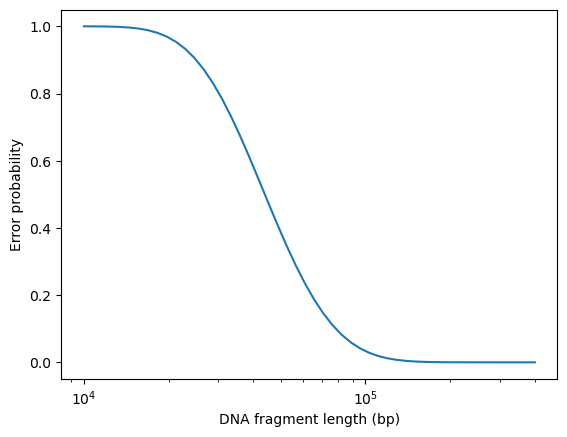

In [19]:
plt.plot(pattern_tool.fragment_len, pattern_tool.p_err)
plt.xscale('log')
plt.xlabel(MOLECULE_LENGTH)
plt.ylabel(ERROR_PROBABILITY)